In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns

In [2]:
exp_dir_path = "/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17"
seed_dirs = glob.glob(os.path.join(exp_dir_path, "seed_*"), recursive=True)
seed_dirs


['/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_0',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_4',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_6',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_8',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_1',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_7',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_2',
 '/mnt/SSD2/nils/uq-method-box/experiments/experiments/uci_DeterministicGaussianModel_energy_05-26-2023_20-06-17/seed_9',
 '/mnt/SSD2/nils/uq-meth

# Full training runs Dataframe

Holds information about the training itself

In [3]:
full_train_df = pd.DataFrame()
for dir in seed_dirs:
    df = pd.read_csv(os.path.join(dir, "model_0", "csv_logs", "version_0", "metrics.csv"))
    df["seed"] = dir.split("_")[-1]
    full_train_df = pd.concat([full_train_df, df], ignore_index=True)
full_train_df = full_train_df.sort_values(by="seed")

# Inspect Training Results

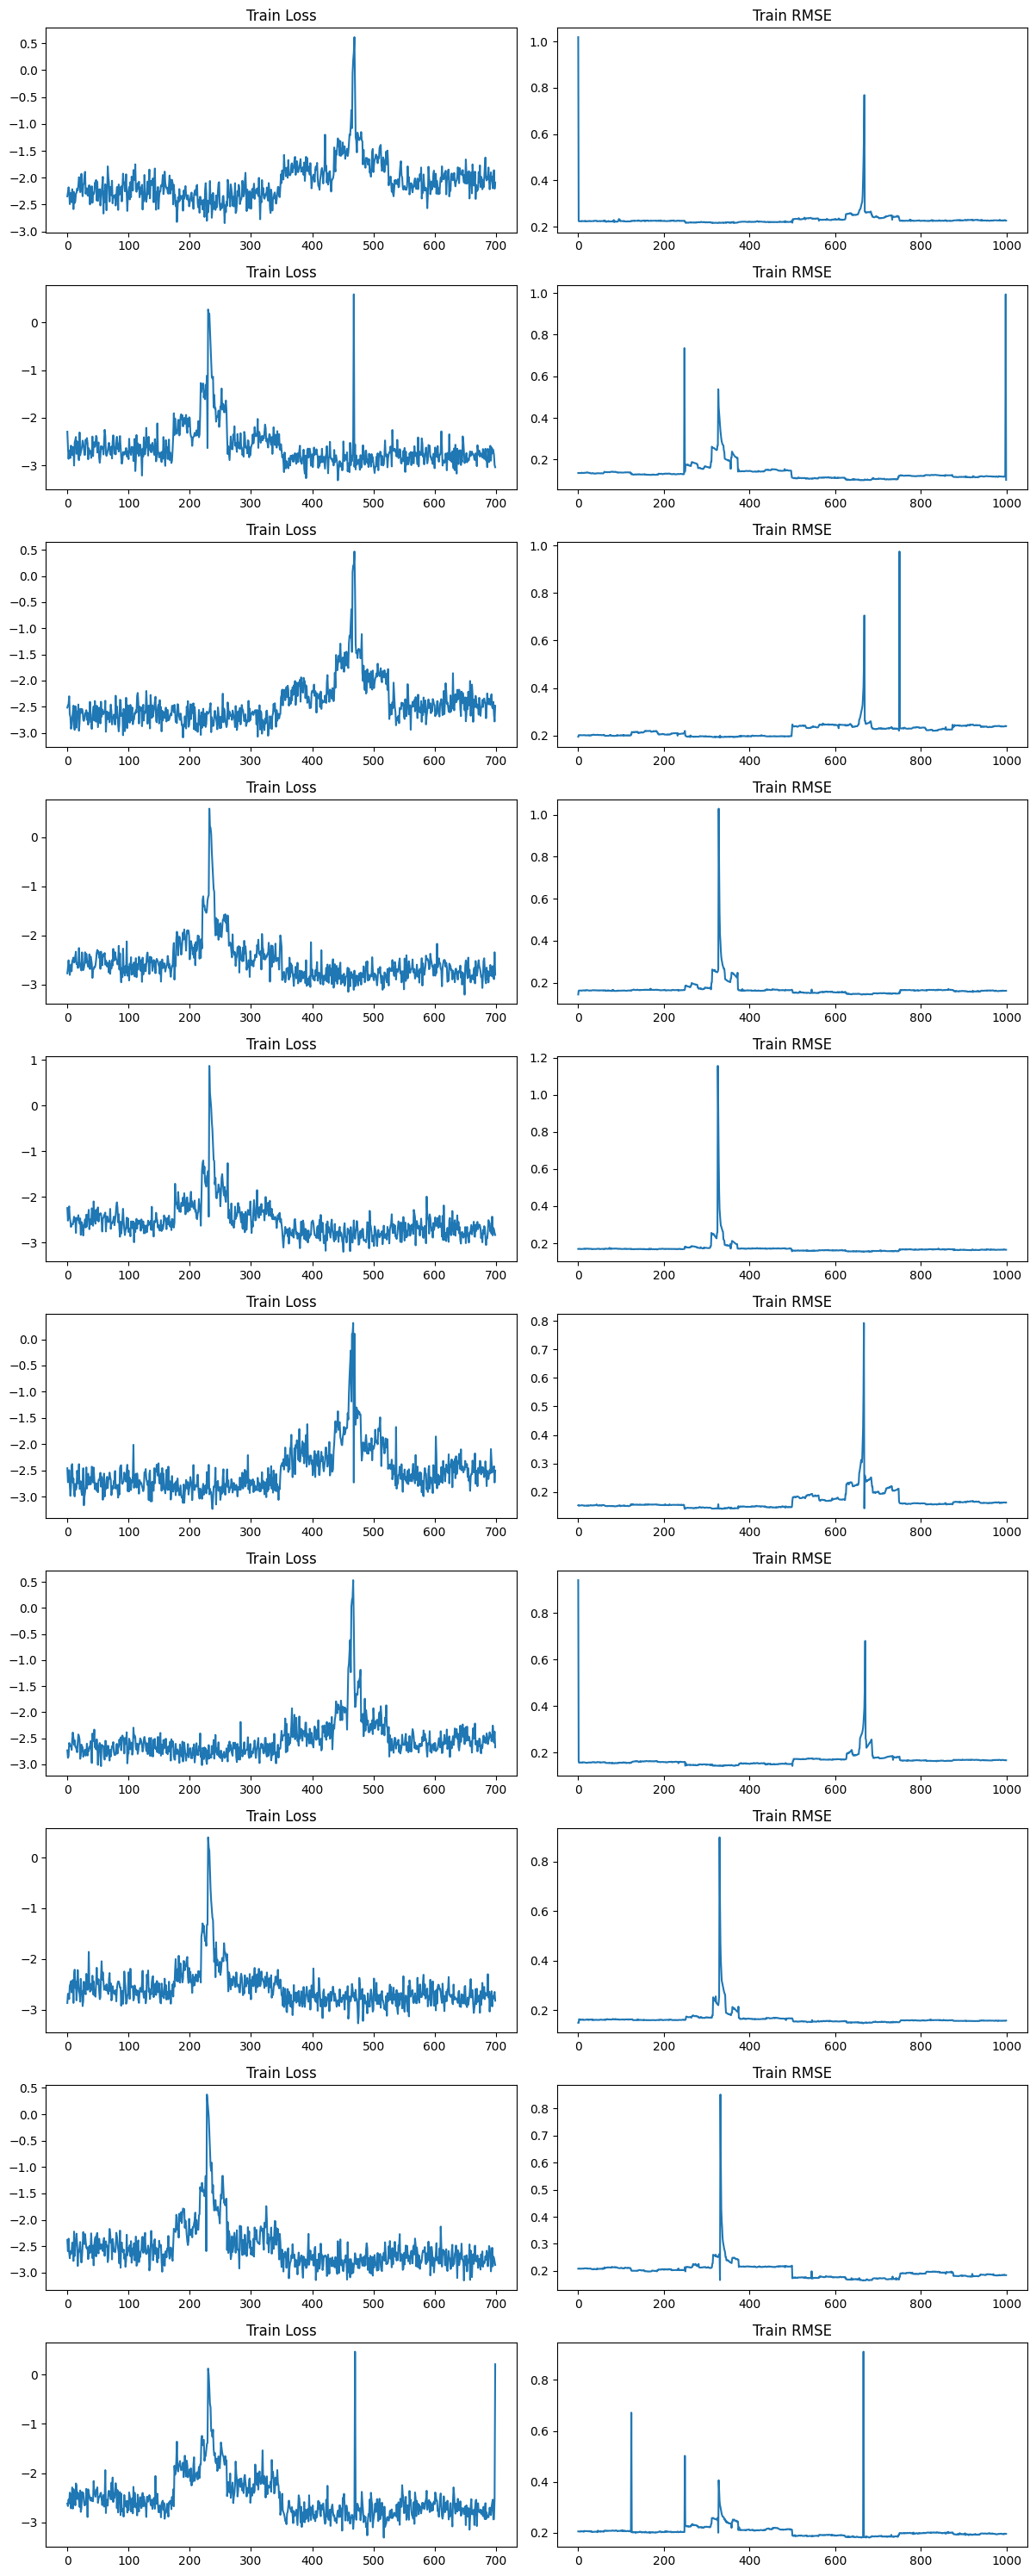

In [4]:
fig, axs = plt.subplots(nrows=len(seed_dirs), ncols=2, figsize=(12, 3*len(seed_dirs)))
for idx in range(len(seed_dirs)):
    run_df = full_train_df[full_train_df["seed"] == str(idx)]
    train_loss = run_df[run_df["train_loss"].notna()]["train_loss"]
    train_rmse = run_df[run_df["train_RMSE"].notna()]["train_RMSE"]
    axs[idx, 0].plot(np.arange(len(train_loss)), train_loss)
    axs[idx, 0].set_title("Train Loss")
    axs[idx, 1].plot(np.arange(len(train_rmse)), train_rmse)
    axs[idx, 1].set_title("Train RMSE")
plt.tight_layout()

# Predictions DataFrame

In [5]:
full_metric_df = pd.DataFrame()
full_metric_df_unnorm = pd.DataFrame()
uq_metric_categories = ["scoring_rule", "avg_calibration", "sharpness", "accuracy"]
for dir in tqdm(seed_dirs):
    pred_df = pd.read_csv(os.path.join(dir, "prediction", "predictions.csv"))
    # normalized
    uq_metrics = uct.metrics.get_all_metrics(
            pred_df["mean"].values.squeeze(),
            pred_df["pred_uct"].values.squeeze(),
            pred_df["targets"].values.squeeze(),
            verbose=False,
        )
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}  
    metric_df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T
    metric_df.columns = metric_df.columns.droplevel(0)
    metric_df["seed"] = dir.split("_")[-1]
    full_metric_df = pd.concat([full_metric_df, metric_df], ignore_index=True)

    # unnormalized
    # normalized
    uq_metrics = uct.metrics.get_all_metrics(
            pred_df["unnorm_mean"].values.squeeze(),
            pred_df["unnorm_std"].values.squeeze(),
            pred_df["unnorm_targets"].values.squeeze(),
            verbose=False,
        )
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}  
    metric_df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T
    metric_df.columns = metric_df.columns.droplevel(0)
    metric_df["seed"] = dir.split("_")[-1]
    full_metric_df_unnorm = pd.concat([full_metric_df_unnorm, metric_df], ignore_index=True)


# long format df for sns
full_metric_long_df = full_metric_df.melt(id_vars="seed")
full_metric_long_df.columns = ["seed", "uq_metric", "value"]

full_metric_unnorm_long_df = full_metric_df_unnorm.melt(id_vars="seed")
full_metric_unnorm_long_df.columns = ["seed", "uq_metric", "value"]

full_metric_df

100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,mdae,marpd,r2,corr,seed
0,1.041787,0.088643,0.044747,0.410653,0.165646,0.152987,0.154532,0.214401,0.136204,0.253591,0.033789,20.077171,0.945107,0.972566,0
1,-1.743391,0.049260,0.024875,0.220410,0.030140,0.024935,0.025009,0.137391,0.074896,0.160765,0.022085,13.979715,0.971878,0.986860,4
2,-1.734689,0.047850,0.024163,0.217997,0.040969,0.035253,0.035480,0.117324,0.070310,0.151287,0.023066,9.910854,0.976742,0.989922,6
3,-1.754661,0.040059,0.020227,0.193202,0.056427,0.042006,0.042149,0.126665,0.057635,0.142186,0.018555,8.862248,0.982521,0.991952,8
4,-1.330282,0.054041,0.027289,0.255252,0.109979,0.090808,0.091563,0.096915,0.076593,0.138742,0.023964,14.518731,0.979359,0.991308,1
5,-0.134976,0.051212,0.025848,0.254365,0.112517,0.085945,0.086695,0.105730,0.071291,0.156037,0.018535,12.388348,0.974126,0.988911,7
6,-1.296998,0.092288,0.046604,0.424208,0.131335,0.121299,0.122524,0.170549,0.134113,0.267511,0.032946,19.983283,0.917919,0.964454,2
7,-1.588425,0.077190,0.038979,0.339910,0.117572,0.099264,0.100242,0.172383,0.115357,0.248504,0.023833,16.895109,0.938482,0.975916,9
8,-1.416782,0.060273,0.030434,0.275290,0.042722,0.033766,0.034012,0.167087,0.092356,0.183277,0.028134,15.882144,0.964020,0.983952,5
9,-1.261774,0.057996,0.029280,0.276089,0.127881,0.110173,0.111261,0.110007,0.083083,0.171027,0.023971,12.845289,0.968871,0.986562,3


# Test Metrics Results

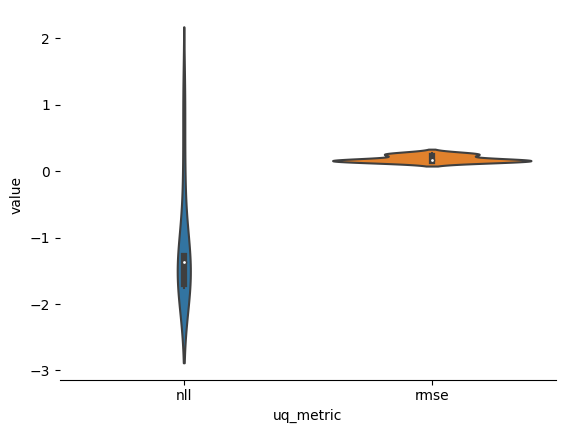

In [6]:
# select metrics you want to see violin plot for
violin_metrics = ["nll", "rmse"]
sns.violinplot(data=full_metric_long_df[full_metric_long_df["uq_metric"].isin(violin_metrics)], x="uq_metric", y="value")
sns.despine(left=True)

Text(0.5, 0, 'Seed')

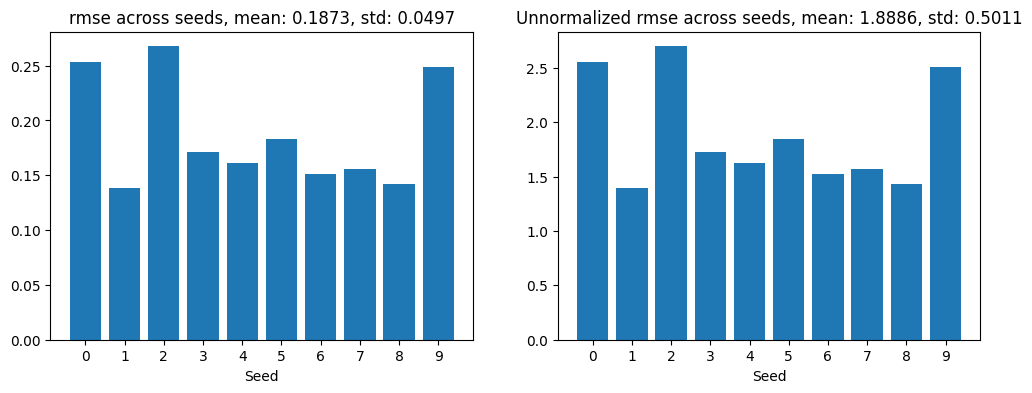

In [9]:
# select one of the available metrics in `full_metric_df`
metric = "rmse"
single_metric_df = full_metric_long_df[full_metric_long_df["uq_metric"]==metric].sort_values(by="seed")
single_metric_unnorm_df = full_metric_unnorm_long_df[full_metric_unnorm_long_df["uq_metric"]==metric].sort_values(by="seed")
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].bar(single_metric_df["seed"], single_metric_df["value"])
ax[0].set_title(f"{metric} across seeds, mean: {single_metric_df['value'].mean():.4f}, std: {single_metric_df['value'].std():.4f}")
ax[0].set_xlabel("Seed")

ax[1].bar(single_metric_unnorm_df["seed"], single_metric_unnorm_df["value"])
ax[1].set_title(f"Unnormalized {metric} across seeds, mean: {single_metric_unnorm_df['value'].mean():.4f}, std: {single_metric_unnorm_df['value'].std():.4f}")
ax[1].set_xlabel("Seed")